In [1]:
#from attention import AttentionLayer
from keras.layers.attention import AttentionLayer



Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow
import pandas as pd 
import re
from bs4 import BeautifulSoup     #Beautiful Soup transforms a complex HTML document into a complex tree of Python objects
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:

data=pd.read_csv("Reviews.csv",nrows=30000)

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28676 entries, 0 to 29999
Data columns (total 10 columns):
Id                        28676 non-null int64
ProductId                 28676 non-null object
UserId                    28676 non-null object
ProfileName               28676 non-null object
HelpfulnessNumerator      28676 non-null int64
HelpfulnessDenominator    28676 non-null int64
Score                     28676 non-null int64
Time                      28676 non-null int64
Summary                   28676 non-null object
Text                      28676 non-null object
dtypes: int64(5), object(5)
memory usage: 2.4+ MB


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have","you're": "you are", "you've": "you have"}

In [7]:

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newstring=text.lower()
    newstring=BeautifulSoup(newstring,"lxml").text
    newstring=re.sub(r'\([^)]*\)','',newstring)
    newstring=re.sub(r'"','',newstring)
    newstring=' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newstring.split(" ")])
    newstring=re.sub(r"'s\b",'',newstring)
    newstring = re.sub("[^a-zA-Z]", " ", newstring) 
    newstring = re.sub('[m]{2,}', 'mm', newstring)
    
    if(num==0):
        tokens = [w for w in newstring.split() if not w in stop_words]
    else:
        tokens=newstring.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()
    


In [8]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [9]:
print(cleaned_text[:5])

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [10]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [11]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [12]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [15]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)
%matplotlib inline 

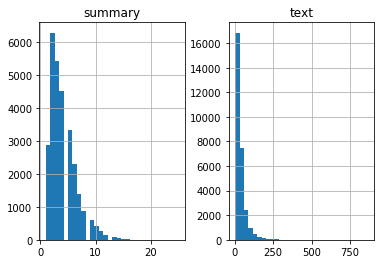

In [16]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [17]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.943771596104848


In [18]:
max_text_len=30
max_summary_len=8

In [19]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [20]:
#Now we will add some special token at atsrt and at the end of summary

df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [21]:
#spliting into training and testing data

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [22]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [23]:
thresh=4     #words below this count considered as rare words

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.31929675315469
Total Coverage of rare words: 5.210999853155373


In [24]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq =x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1

In [25]:
x_voc

4752

In [26]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [27]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.84362139917695
Total Coverage of rare words: 8.987963039126978


In [28]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [29]:

y_tokenizer.word_counts['sostok'],len(y_tr)


(13970, 13970)

In [30]:

y_voc

932

In [31]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [32]:

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)


In [33]:
#model building
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as k
k.clear_session()

latent_dim=300
embedding_dim=300

#encoder
encoder_inputs=Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs,decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

W1205 18:16:23.066881  4312 deprecation_wrapper.py:119] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



W1205 18:16:23.070924  4312 deprecation_wrapper.py:119] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



W1205 18:16:23.269856  4312 deprecation_wrapper.py:119] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.


W1205 18:16:23.285044  4312 deprecation.py:506] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W1205 18:16:23.375560  4312 deprecation.py:506] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 300)      1425600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 30, 300), (N 721200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


In [36]:



history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],
                  batch_size=128, validation_data=([x_val,y_val[:,:-1]], 
                                                   y_val.reshape(y_val.shape[0],y_val.shape[1],1)[:,1:]))





Train on 13375 samples, validate on 1474 samples


W1205 18:16:30.251088  4312 deprecation.py:323] From C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5


  128/13375 [..............................] - ETA: 30:56 - loss: 6.8356

  256/13375 [..............................] - ETA: 16:04 - loss: 6.7839

  384/13375 [..............................] - ETA: 11:05 - loss: 6.1162

  512/13375 [>.............................] - ETA: 8:34 - loss: 5.6868 

  640/13375 [>.............................] - ETA: 7:03 - loss: 5.3194

  768/13375 [>.............................] - ETA: 6:02 - loss: 4.9629

  896/13375 [=>............................] - ETA: 5:19 - loss: 4.7014

 1024/13375 [=>............................] - ETA: 4:46 - loss: 4.4952

 1152/13375 [=>............................] - ETA: 4:20 - loss: 4.3417

 1280/13375 [=>............................] - ETA: 3:59 - loss: 4.1801

 1408/13375 [==>...........................] - ETA: 3:42 - loss: 4.0710

 1536/13375 [==>...........................] - ETA: 3:28 - loss: 3.9591

 1664/13375 [==>...........................] - ETA: 3:16 - loss: 3.8725

 1792/13375 [===>..........................] - ETA: 3:05 - loss: 3.8087

 1920/13375 [===>..........................] - ETA: 2:55 - loss: 3.7580

 2048/13375 [===>..........................] - ETA: 2:47 - loss: 3.7113

 2176/13375 [===>..........................] - ETA: 2:40 - loss: 3.6665

 2304/13375 [====>.........................] - ETA: 2:33 - loss: 3.6247

 2432/13375 [====>.........................] - ETA: 2:27 - loss: 3.5797

 2560/13375 [====>.........................] - ETA: 2:22 - loss: 3.5468

 2688/13375 [=====>........................] - ETA: 2:16 - loss: 3.5174

 2816/13375 [=====>........................] - ETA: 2:12 - loss: 3.4829

 2944/13375 [=====>........................] - ETA: 2:07 - loss: 3.4470

 3072/13375 [=====>........................] - ETA: 2:03 - loss: 3.4125

 3200/13375 [======>.......................] - ETA: 2:00 - loss: 3.3810

 3328/13375 [======>.......................] - ETA: 1:56 - loss: 3.3589

 3456/13375 [======>.......................] - ETA: 1:53 - loss: 3.3332

 3584/13375 [=======>......................] - ETA: 1:49 - loss: 3.3163

 3712/13375 [=======>......................] - ETA: 1:46 - loss: 3.2968

 3840/13375 [=======>......................] - ETA: 1:44 - loss: 3.2817

 3968/13375 [=======>......................] - ETA: 1:41 - loss: 3.2678

 4096/13375 [========>.....................] - ETA: 1:38 - loss: 3.2507

 4224/13375 [========>.....................] - ETA: 1:36 - loss: 3.2362

 4352/13375 [========>.....................] - ETA: 1:33 - loss: 3.2173

 4480/13375 [=========>....................] - ETA: 1:31 - loss: 3.2073

 4608/13375 [=========>....................] - ETA: 1:29 - loss: 3.1922

 4736/13375 [=========>....................] - ETA: 1:26 - loss: 3.1787

 4864/13375 [=========>....................] - ETA: 1:24 - loss: 3.1669

 4992/13375 [==========>...................] - ETA: 1:22 - loss: 3.1586

 5120/13375 [==========>...................] - ETA: 1:20 - loss: 3.1478

 5248/13375 [==========>...................] - ETA: 1:18 - loss: 3.1320

 5376/13375 [===========>..................] - ETA: 1:16 - loss: 3.1191

 5504/13375 [===========>..................] - ETA: 1:15 - loss: 3.1098

 5632/13375 [===========>..................] - ETA: 1:13 - loss: 3.0939

 5760/13375 [===========>..................] - ETA: 1:11 - loss: 3.0853

 5888/13375 [============>.................] - ETA: 1:10 - loss: 3.0746

 6016/13375 [============>.................] - ETA: 1:08 - loss: 3.0677

 6144/13375 [============>.................] - ETA: 1:06 - loss: 3.0605

 6272/13375 [=============>................] - ETA: 1:05 - loss: 3.0476

 6400/13375 [=============>................] - ETA: 1:03 - loss: 3.0343

 6528/13375 [=============>................] - ETA: 1:02 - loss: 3.0280

 6656/13375 [=============>................] - ETA: 1:00 - loss: 3.0169

 6784/13375 [==============>...............] - ETA: 59s - loss: 3.0088 

 6912/13375 [==============>...............] - ETA: 57s - loss: 3.0011

 7040/13375 [==============>...............] - ETA: 56s - loss: 2.9931

 7168/13375 [===============>..............] - ETA: 54s - loss: 2.9857

 7296/13375 [===============>..............] - ETA: 53s - loss: 2.9801

 7424/13375 [===============>..............] - ETA: 52s - loss: 2.9746

 7552/13375 [===============>..............] - ETA: 50s - loss: 2.9657

 7680/13375 [================>.............] - ETA: 49s - loss: 2.9584

 7808/13375 [================>.............] - ETA: 48s - loss: 2.9535

 7936/13375 [================>.............] - ETA: 46s - loss: 2.9445

 8064/13375 [=================>............] - ETA: 45s - loss: 2.9362

 8192/13375 [=================>............] - ETA: 44s - loss: 2.9298

 8320/13375 [=================>............] - ETA: 42s - loss: 2.9204

 8448/13375 [=================>............] - ETA: 41s - loss: 2.9108

 8576/13375 [==================>...........] - ETA: 40s - loss: 2.9078

 8704/13375 [==================>...........] - ETA: 39s - loss: 2.9042

 8832/13375 [==================>...........] - ETA: 38s - loss: 2.8963

 8960/13375 [===================>..........] - ETA: 36s - loss: 2.8887

 9088/13375 [===================>..........] - ETA: 35s - loss: 2.8823

 9216/13375 [===================>..........] - ETA: 34s - loss: 2.8788

 9344/13375 [===================>..........] - ETA: 33s - loss: 2.8715

 9472/13375 [====================>.........] - ETA: 32s - loss: 2.8674

 9600/13375 [====================>.........] - ETA: 31s - loss: 2.8653

 9728/13375 [====================>.........] - ETA: 29s - loss: 2.8572

 9856/13375 [=====================>........] - ETA: 28s - loss: 2.8538

 9984/13375 [=====================>........] - ETA: 27s - loss: 2.8494

10112/13375 [=====================>........] - ETA: 26s - loss: 2.8447

10240/13375 [=====================>........] - ETA: 25s - loss: 2.8431

10368/13375 [======================>.......] - ETA: 24s - loss: 2.8386

10496/13375 [======================>.......] - ETA: 23s - loss: 2.8343

10624/13375 [======================>.......] - ETA: 22s - loss: 2.8317

10752/13375 [=======================>......] - ETA: 21s - loss: 2.8260

10880/13375 [=======================>......] - ETA: 19s - loss: 2.8205

11008/13375 [=======================>......] - ETA: 18s - loss: 2.8151

11136/13375 [=======================>......] - ETA: 17s - loss: 2.8122

11264/13375 [========================>.....] - ETA: 16s - loss: 2.8087

11392/13375 [========================>.....] - ETA: 15s - loss: 2.8050

11520/13375 [========================>.....] - ETA: 14s - loss: 2.8006

11648/13375 [=========================>....] - ETA: 13s - loss: 2.7976

11776/13375 [=========================>....] - ETA: 12s - loss: 2.7928

11904/13375 [=========================>....] - ETA: 11s - loss: 2.7913

12032/13375 [=========================>....] - ETA: 10s - loss: 2.7882

12160/13375 [==========================>...] - ETA: 9s - loss: 2.7859 

12288/13375 [==========================>...] - ETA: 8s - loss: 2.7844

12416/13375 [==========================>...] - ETA: 7s - loss: 2.7793

12544/13375 [===========================>..] - ETA: 6s - loss: 2.7741

12672/13375 [===========================>..] - ETA: 5s - loss: 2.7712

12800/13375 [===========================>..] - ETA: 4s - loss: 2.7687

12928/13375 [===========================>..] - ETA: 3s - loss: 2.7666

13056/13375 [============================>.] - ETA: 2s - loss: 2.7628

13184/13375 [============================>.] - ETA: 1s - loss: 2.7585

13312/13375 [============================>.] - ETA: 0s - loss: 2.7558

13375/13375 [==============================] - 109s 8ms/sample - loss: 2.7539 - val_loss: 2.4207


Epoch 2/5


  128/13375 [..............................] - ETA: 1:30 - loss: 2.3564

  256/13375 [..............................] - ETA: 1:27 - loss: 2.3497

  384/13375 [..............................] - ETA: 1:25 - loss: 2.3783

  512/13375 [>.............................] - ETA: 1:26 - loss: 2.4073

  640/13375 [>.............................] - ETA: 1:25 - loss: 2.4004

  768/13375 [>.............................] - ETA: 1:24 - loss: 2.4014

  896/13375 [=>............................] - ETA: 1:23 - loss: 2.4226

 1024/13375 [=>............................] - ETA: 1:22 - loss: 2.4442

 1152/13375 [=>............................] - ETA: 1:21 - loss: 2.4208

 1280/13375 [=>............................] - ETA: 1:20 - loss: 2.4054

 1408/13375 [==>...........................] - ETA: 1:19 - loss: 2.4089

 1536/13375 [==>...........................] - ETA: 1:18 - loss: 2.4066

 1664/13375 [==>...........................] - ETA: 1:17 - loss: 2.4016

 1792/13375 [===>..........................] - ETA: 1:16 - loss: 2.4071

 1920/13375 [===>..........................] - ETA: 1:15 - loss: 2.4113

 2048/13375 [===>..........................] - ETA: 1:14 - loss: 2.4189

 2176/13375 [===>..........................] - ETA: 1:13 - loss: 2.4239

 2304/13375 [====>.........................] - ETA: 1:12 - loss: 2.4224

 2432/13375 [====>.........................] - ETA: 1:11 - loss: 2.4193

 2560/13375 [====>.........................] - ETA: 1:10 - loss: 2.4240

 2688/13375 [=====>........................] - ETA: 1:10 - loss: 2.4241

 2816/13375 [=====>........................] - ETA: 1:09 - loss: 2.4216

 2944/13375 [=====>........................] - ETA: 1:08 - loss: 2.4154

 3072/13375 [=====>........................] - ETA: 1:07 - loss: 2.4200

 3200/13375 [======>.......................] - ETA: 1:06 - loss: 2.4183

 3328/13375 [======>.......................] - ETA: 1:05 - loss: 2.4185

 3456/13375 [======>.......................] - ETA: 1:04 - loss: 2.4162

 3584/13375 [=======>......................] - ETA: 1:03 - loss: 2.4197

 3712/13375 [=======>......................] - ETA: 1:03 - loss: 2.4220

 3840/13375 [=======>......................] - ETA: 1:02 - loss: 2.4167

 3968/13375 [=======>......................] - ETA: 1:01 - loss: 2.4127

 4096/13375 [========>.....................] - ETA: 1:00 - loss: 2.4172

 4224/13375 [========>.....................] - ETA: 59s - loss: 2.4123 

 4352/13375 [========>.....................] - ETA: 58s - loss: 2.4092

 4480/13375 [=========>....................] - ETA: 57s - loss: 2.4104

 4608/13375 [=========>....................] - ETA: 57s - loss: 2.4123

 4736/13375 [=========>....................] - ETA: 56s - loss: 2.4103

 4864/13375 [=========>....................] - ETA: 55s - loss: 2.4091

 4992/13375 [==========>...................] - ETA: 54s - loss: 2.4068

 5120/13375 [==========>...................] - ETA: 53s - loss: 2.4033

 5248/13375 [==========>...................] - ETA: 52s - loss: 2.3961

 5376/13375 [===========>..................] - ETA: 52s - loss: 2.3965

 5504/13375 [===========>..................] - ETA: 51s - loss: 2.4024

 5632/13375 [===========>..................] - ETA: 50s - loss: 2.4035

 5760/13375 [===========>..................] - ETA: 49s - loss: 2.4051

 5888/13375 [============>.................] - ETA: 48s - loss: 2.4057

 6016/13375 [============>.................] - ETA: 47s - loss: 2.4027

 6144/13375 [============>.................] - ETA: 47s - loss: 2.4008

 6272/13375 [=============>................] - ETA: 46s - loss: 2.4010

 6400/13375 [=============>................] - ETA: 45s - loss: 2.3967

 6528/13375 [=============>................] - ETA: 44s - loss: 2.3962

 6656/13375 [=============>................] - ETA: 43s - loss: 2.3922

 6784/13375 [==============>...............] - ETA: 42s - loss: 2.3919

 6912/13375 [==============>...............] - ETA: 42s - loss: 2.3932

 7040/13375 [==============>...............] - ETA: 41s - loss: 2.3953

 7168/13375 [===============>..............] - ETA: 40s - loss: 2.3974

 7296/13375 [===============>..............] - ETA: 39s - loss: 2.3998

 7424/13375 [===============>..............] - ETA: 38s - loss: 2.3977

 7552/13375 [===============>..............] - ETA: 37s - loss: 2.3957

 7680/13375 [================>.............] - ETA: 37s - loss: 2.3931

 7808/13375 [================>.............] - ETA: 36s - loss: 2.3923

 7936/13375 [================>.............] - ETA: 35s - loss: 2.3975

 8064/13375 [=================>............] - ETA: 34s - loss: 2.3961

 8192/13375 [=================>............] - ETA: 33s - loss: 2.3941

 8320/13375 [=================>............] - ETA: 32s - loss: 2.3963

 8448/13375 [=================>............] - ETA: 32s - loss: 2.3960

 8576/13375 [==================>...........] - ETA: 31s - loss: 2.3942

 8704/13375 [==================>...........] - ETA: 30s - loss: 2.3960

 8832/13375 [==================>...........] - ETA: 29s - loss: 2.3947

 8960/13375 [===================>..........] - ETA: 28s - loss: 2.3962

 9088/13375 [===================>..........] - ETA: 27s - loss: 2.3948

 9216/13375 [===================>..........] - ETA: 27s - loss: 2.3927

 9344/13375 [===================>..........] - ETA: 26s - loss: 2.3910

 9472/13375 [====================>.........] - ETA: 25s - loss: 2.3912

 9600/13375 [====================>.........] - ETA: 24s - loss: 2.3902

 9728/13375 [====================>.........] - ETA: 23s - loss: 2.3890

 9856/13375 [=====================>........] - ETA: 22s - loss: 2.3891

 9984/13375 [=====================>........] - ETA: 21s - loss: 2.3889

10112/13375 [=====================>........] - ETA: 21s - loss: 2.3910

10240/13375 [=====================>........] - ETA: 20s - loss: 2.3878

10368/13375 [======================>.......] - ETA: 19s - loss: 2.3886

10496/13375 [======================>.......] - ETA: 18s - loss: 2.3871

10624/13375 [======================>.......] - ETA: 17s - loss: 2.3866

10752/13375 [=======================>......] - ETA: 16s - loss: 2.3871

10880/13375 [=======================>......] - ETA: 16s - loss: 2.3895

11008/13375 [=======================>......] - ETA: 15s - loss: 2.3899

11136/13375 [=======================>......] - ETA: 14s - loss: 2.3866

11264/13375 [========================>.....] - ETA: 13s - loss: 2.3853

11392/13375 [========================>.....] - ETA: 12s - loss: 2.3866

11520/13375 [========================>.....] - ETA: 12s - loss: 2.3863

11648/13375 [=========================>....] - ETA: 11s - loss: 2.3853

11776/13375 [=========================>....] - ETA: 10s - loss: 2.3840

11904/13375 [=========================>....] - ETA: 9s - loss: 2.3825 

12032/13375 [=========================>....] - ETA: 8s - loss: 2.3810

12160/13375 [==========================>...] - ETA: 7s - loss: 2.3816

12288/13375 [==========================>...] - ETA: 7s - loss: 2.3796

12416/13375 [==========================>...] - ETA: 6s - loss: 2.3786

12544/13375 [===========================>..] - ETA: 5s - loss: 2.3760

12672/13375 [===========================>..] - ETA: 4s - loss: 2.3761

12800/13375 [===========================>..] - ETA: 3s - loss: 2.3744

12928/13375 [===========================>..] - ETA: 2s - loss: 2.3750

13056/13375 [============================>.] - ETA: 2s - loss: 2.3759

13184/13375 [============================>.] - ETA: 1s - loss: 2.3738

13312/13375 [============================>.] - ETA: 0s - loss: 2.3749

13375/13375 [==============================] - 91s 7ms/sample - loss: 2.3742 - val_loss: 2.2988


Epoch 3/5


  128/13375 [..............................] - ETA: 1:30 - loss: 2.4704

  256/13375 [..............................] - ETA: 1:27 - loss: 2.5028

  384/13375 [..............................] - ETA: 1:25 - loss: 2.4395

  512/13375 [>.............................] - ETA: 1:23 - loss: 2.3840

  640/13375 [>.............................] - ETA: 1:22 - loss: 2.3327

  768/13375 [>.............................] - ETA: 1:22 - loss: 2.3189

  896/13375 [=>............................] - ETA: 1:20 - loss: 2.2976

 1024/13375 [=>............................] - ETA: 1:20 - loss: 2.2861

 1152/13375 [=>............................] - ETA: 1:18 - loss: 2.2810

 1280/13375 [=>............................] - ETA: 1:17 - loss: 2.2728

 1408/13375 [==>...........................] - ETA: 1:17 - loss: 2.2757

 1536/13375 [==>...........................] - ETA: 1:16 - loss: 2.2769

 1664/13375 [==>...........................] - ETA: 1:15 - loss: 2.2806

 1792/13375 [===>..........................] - ETA: 1:15 - loss: 2.2841

 1920/13375 [===>..........................] - ETA: 1:14 - loss: 2.2754

 2048/13375 [===>..........................] - ETA: 1:13 - loss: 2.2702

 2176/13375 [===>..........................] - ETA: 1:12 - loss: 2.2709

 2304/13375 [====>.........................] - ETA: 1:11 - loss: 2.2716

 2432/13375 [====>.........................] - ETA: 1:10 - loss: 2.2800

 2560/13375 [====>.........................] - ETA: 1:09 - loss: 2.2793

 2688/13375 [=====>........................] - ETA: 1:09 - loss: 2.2724

 2816/13375 [=====>........................] - ETA: 1:08 - loss: 2.2680

 2944/13375 [=====>........................] - ETA: 1:07 - loss: 2.2651

 3072/13375 [=====>........................] - ETA: 1:06 - loss: 2.2647

 3200/13375 [======>.......................] - ETA: 1:05 - loss: 2.2617

 3328/13375 [======>.......................] - ETA: 1:04 - loss: 2.2608

 3456/13375 [======>.......................] - ETA: 1:04 - loss: 2.2562

 3584/13375 [=======>......................] - ETA: 1:03 - loss: 2.2628

 3712/13375 [=======>......................] - ETA: 1:02 - loss: 2.2559

 3840/13375 [=======>......................] - ETA: 1:01 - loss: 2.2527

 3968/13375 [=======>......................] - ETA: 1:00 - loss: 2.2537

 4096/13375 [========>.....................] - ETA: 59s - loss: 2.2466 

 4224/13375 [========>.....................] - ETA: 58s - loss: 2.2503

 4352/13375 [========>.....................] - ETA: 58s - loss: 2.2517

 4480/13375 [=========>....................] - ETA: 57s - loss: 2.2526

 4608/13375 [=========>....................] - ETA: 56s - loss: 2.2537

 4736/13375 [=========>....................] - ETA: 55s - loss: 2.2557

 4864/13375 [=========>....................] - ETA: 54s - loss: 2.2563

 4992/13375 [==========>...................] - ETA: 54s - loss: 2.2628

 5120/13375 [==========>...................] - ETA: 53s - loss: 2.2631

 5248/13375 [==========>...................] - ETA: 52s - loss: 2.2615

 5376/13375 [===========>..................] - ETA: 51s - loss: 2.2598

 5504/13375 [===========>..................] - ETA: 50s - loss: 2.2584

 5632/13375 [===========>..................] - ETA: 49s - loss: 2.2557

 5760/13375 [===========>..................] - ETA: 49s - loss: 2.2562

 5888/13375 [============>.................] - ETA: 48s - loss: 2.2581

 6016/13375 [============>.................] - ETA: 47s - loss: 2.2579

 6144/13375 [============>.................] - ETA: 46s - loss: 2.2570

 6272/13375 [=============>................] - ETA: 45s - loss: 2.2552

 6400/13375 [=============>................] - ETA: 44s - loss: 2.2546

 6528/13375 [=============>................] - ETA: 44s - loss: 2.2539

 6656/13375 [=============>................] - ETA: 43s - loss: 2.2535

 6784/13375 [==============>...............] - ETA: 42s - loss: 2.2500

 6912/13375 [==============>...............] - ETA: 41s - loss: 2.2503

 7040/13375 [==============>...............] - ETA: 40s - loss: 2.2481

 7168/13375 [===============>..............] - ETA: 40s - loss: 2.2492

 7296/13375 [===============>..............] - ETA: 39s - loss: 2.2471

 7424/13375 [===============>..............] - ETA: 38s - loss: 2.2480

 7552/13375 [===============>..............] - ETA: 37s - loss: 2.2490

 7680/13375 [================>.............] - ETA: 36s - loss: 2.2477

 7808/13375 [================>.............] - ETA: 35s - loss: 2.2466

 7936/13375 [================>.............] - ETA: 35s - loss: 2.2475

 8064/13375 [=================>............] - ETA: 34s - loss: 2.2496

 8192/13375 [=================>............] - ETA: 33s - loss: 2.2519

 8320/13375 [=================>............] - ETA: 32s - loss: 2.2511

 8448/13375 [=================>............] - ETA: 31s - loss: 2.2499

 8576/13375 [==================>...........] - ETA: 31s - loss: 2.2494

 8704/13375 [==================>...........] - ETA: 30s - loss: 2.2487

 8832/13375 [==================>...........] - ETA: 29s - loss: 2.2471

 8960/13375 [===================>..........] - ETA: 28s - loss: 2.2481

 9088/13375 [===================>..........] - ETA: 27s - loss: 2.2483

 9216/13375 [===================>..........] - ETA: 26s - loss: 2.2489

 9344/13375 [===================>..........] - ETA: 26s - loss: 2.2524

 9472/13375 [====================>.........] - ETA: 25s - loss: 2.2513

 9600/13375 [====================>.........] - ETA: 24s - loss: 2.2482

 9728/13375 [====================>.........] - ETA: 23s - loss: 2.2467

 9856/13375 [=====================>........] - ETA: 22s - loss: 2.2443

 9984/13375 [=====================>........] - ETA: 21s - loss: 2.2430

10112/13375 [=====================>........] - ETA: 21s - loss: 2.2418

10240/13375 [=====================>........] - ETA: 20s - loss: 2.2400

10368/13375 [======================>.......] - ETA: 19s - loss: 2.2413

10496/13375 [======================>.......] - ETA: 18s - loss: 2.2395

10624/13375 [======================>.......] - ETA: 17s - loss: 2.2390

10752/13375 [=======================>......] - ETA: 16s - loss: 2.2400

10880/13375 [=======================>......] - ETA: 16s - loss: 2.2412

11008/13375 [=======================>......] - ETA: 15s - loss: 2.2423

11136/13375 [=======================>......] - ETA: 14s - loss: 2.2440

11264/13375 [========================>.....] - ETA: 13s - loss: 2.2440

11392/13375 [========================>.....] - ETA: 12s - loss: 2.2429

11520/13375 [========================>.....] - ETA: 11s - loss: 2.2418

11648/13375 [=========================>....] - ETA: 11s - loss: 2.2411

11776/13375 [=========================>....] - ETA: 10s - loss: 2.2428

11904/13375 [=========================>....] - ETA: 9s - loss: 2.2443 

12032/13375 [=========================>....] - ETA: 8s - loss: 2.2436

12160/13375 [==========================>...] - ETA: 7s - loss: 2.2450

12288/13375 [==========================>...] - ETA: 7s - loss: 2.2453

12416/13375 [==========================>...] - ETA: 6s - loss: 2.2467

12544/13375 [===========================>..] - ETA: 5s - loss: 2.2464

12672/13375 [===========================>..] - ETA: 4s - loss: 2.2454

12800/13375 [===========================>..] - ETA: 3s - loss: 2.2450

12928/13375 [===========================>..] - ETA: 2s - loss: 2.2483

13056/13375 [============================>.] - ETA: 2s - loss: 2.2500

13184/13375 [============================>.] - ETA: 1s - loss: 2.2496

13312/13375 [============================>.] - ETA: 0s - loss: 2.2503

13375/13375 [==============================] - 91s 7ms/sample - loss: 2.2497 - val_loss: 2.2033


Epoch 4/5


  128/13375 [..............................] - ETA: 1:29 - loss: 2.0364

  256/13375 [..............................] - ETA: 1:27 - loss: 2.0983

  384/13375 [..............................] - ETA: 1:25 - loss: 2.1408

  512/13375 [>.............................] - ETA: 1:24 - loss: 2.1248

  640/13375 [>.............................] - ETA: 1:23 - loss: 2.1090

  768/13375 [>.............................] - ETA: 1:21 - loss: 2.0986

  896/13375 [=>............................] - ETA: 1:21 - loss: 2.0883

 1024/13375 [=>............................] - ETA: 1:20 - loss: 2.1078

 1152/13375 [=>............................] - ETA: 1:19 - loss: 2.0892

 1280/13375 [=>............................] - ETA: 1:18 - loss: 2.1072

 1408/13375 [==>...........................] - ETA: 1:18 - loss: 2.1097

 1536/13375 [==>...........................] - ETA: 1:17 - loss: 2.1224

 1664/13375 [==>...........................] - ETA: 1:16 - loss: 2.1256

 1792/13375 [===>..........................] - ETA: 1:15 - loss: 2.1336

 1920/13375 [===>..........................] - ETA: 1:14 - loss: 2.1458

 2048/13375 [===>..........................] - ETA: 1:13 - loss: 2.1543

 2176/13375 [===>..........................] - ETA: 1:13 - loss: 2.1587

 2304/13375 [====>.........................] - ETA: 1:12 - loss: 2.1499

 2432/13375 [====>.........................] - ETA: 1:11 - loss: 2.1590

 2560/13375 [====>.........................] - ETA: 1:10 - loss: 2.1671

 2688/13375 [=====>........................] - ETA: 1:09 - loss: 2.1638

 2816/13375 [=====>........................] - ETA: 1:08 - loss: 2.1681

 2944/13375 [=====>........................] - ETA: 1:07 - loss: 2.1725

 3072/13375 [=====>........................] - ETA: 1:06 - loss: 2.1692

 3200/13375 [======>.......................] - ETA: 1:06 - loss: 2.1684

 3328/13375 [======>.......................] - ETA: 1:05 - loss: 2.1678

 3456/13375 [======>.......................] - ETA: 1:04 - loss: 2.1760

 3584/13375 [=======>......................] - ETA: 1:03 - loss: 2.1733

 3712/13375 [=======>......................] - ETA: 1:02 - loss: 2.1765

 3840/13375 [=======>......................] - ETA: 1:01 - loss: 2.1749

 3968/13375 [=======>......................] - ETA: 1:01 - loss: 2.1740

 4096/13375 [========>.....................] - ETA: 1:00 - loss: 2.1739

 4224/13375 [========>.....................] - ETA: 59s - loss: 2.1771 

 4352/13375 [========>.....................] - ETA: 58s - loss: 2.1736

 4480/13375 [=========>....................] - ETA: 57s - loss: 2.1732

 4608/13375 [=========>....................] - ETA: 56s - loss: 2.1774

 4736/13375 [=========>....................] - ETA: 55s - loss: 2.1751

 4864/13375 [=========>....................] - ETA: 55s - loss: 2.1763

 4992/13375 [==========>...................] - ETA: 54s - loss: 2.1799

 5120/13375 [==========>...................] - ETA: 53s - loss: 2.1780

 5248/13375 [==========>...................] - ETA: 52s - loss: 2.1756

 5376/13375 [===========>..................] - ETA: 51s - loss: 2.1793

 5504/13375 [===========>..................] - ETA: 50s - loss: 2.1763

 5632/13375 [===========>..................] - ETA: 49s - loss: 2.1738

 5760/13375 [===========>..................] - ETA: 49s - loss: 2.1716

 5888/13375 [============>.................] - ETA: 48s - loss: 2.1697

 6016/13375 [============>.................] - ETA: 47s - loss: 2.1682

 6144/13375 [============>.................] - ETA: 46s - loss: 2.1665

 6272/13375 [=============>................] - ETA: 45s - loss: 2.1657

 6400/13375 [=============>................] - ETA: 45s - loss: 2.1637

 6528/13375 [=============>................] - ETA: 44s - loss: 2.1646

 6656/13375 [=============>................] - ETA: 43s - loss: 2.1615

 6784/13375 [==============>...............] - ETA: 42s - loss: 2.1633

 6912/13375 [==============>...............] - ETA: 41s - loss: 2.1644

 7040/13375 [==============>...............] - ETA: 40s - loss: 2.1627

 7168/13375 [===============>..............] - ETA: 40s - loss: 2.1624

 7296/13375 [===============>..............] - ETA: 39s - loss: 2.1615

 7424/13375 [===============>..............] - ETA: 38s - loss: 2.1605

 7552/13375 [===============>..............] - ETA: 37s - loss: 2.1613

 7680/13375 [================>.............] - ETA: 36s - loss: 2.1594

 7808/13375 [================>.............] - ETA: 35s - loss: 2.1615

 7936/13375 [================>.............] - ETA: 35s - loss: 2.1617

 8064/13375 [=================>............] - ETA: 34s - loss: 2.1602

 8192/13375 [=================>............] - ETA: 33s - loss: 2.1606

 8320/13375 [=================>............] - ETA: 32s - loss: 2.1587

 8448/13375 [=================>............] - ETA: 31s - loss: 2.1577

 8576/13375 [==================>...........] - ETA: 30s - loss: 2.1573

 8704/13375 [==================>...........] - ETA: 30s - loss: 2.1560

 8832/13375 [==================>...........] - ETA: 29s - loss: 2.1550

 8960/13375 [===================>..........] - ETA: 28s - loss: 2.1536

 9088/13375 [===================>..........] - ETA: 27s - loss: 2.1525

 9216/13375 [===================>..........] - ETA: 26s - loss: 2.1521

 9344/13375 [===================>..........] - ETA: 26s - loss: 2.1517

 9472/13375 [====================>.........] - ETA: 25s - loss: 2.1538

 9600/13375 [====================>.........] - ETA: 24s - loss: 2.1533

 9728/13375 [====================>.........] - ETA: 23s - loss: 2.1541

 9856/13375 [=====================>........] - ETA: 22s - loss: 2.1523

 9984/13375 [=====================>........] - ETA: 21s - loss: 2.1529

10112/13375 [=====================>........] - ETA: 21s - loss: 2.1522

10240/13375 [=====================>........] - ETA: 20s - loss: 2.1501

10368/13375 [======================>.......] - ETA: 19s - loss: 2.1490

10496/13375 [======================>.......] - ETA: 18s - loss: 2.1484

10624/13375 [======================>.......] - ETA: 17s - loss: 2.1476

10752/13375 [=======================>......] - ETA: 16s - loss: 2.1473

10880/13375 [=======================>......] - ETA: 16s - loss: 2.1480

11008/13375 [=======================>......] - ETA: 15s - loss: 2.1469

11136/13375 [=======================>......] - ETA: 14s - loss: 2.1465

11264/13375 [========================>.....] - ETA: 13s - loss: 2.1451

11392/13375 [========================>.....] - ETA: 12s - loss: 2.1440

11520/13375 [========================>.....] - ETA: 11s - loss: 2.1439

11648/13375 [=========================>....] - ETA: 11s - loss: 2.1435

11776/13375 [=========================>....] - ETA: 10s - loss: 2.1435

11904/13375 [=========================>....] - ETA: 9s - loss: 2.1436 

12032/13375 [=========================>....] - ETA: 8s - loss: 2.1448

12160/13375 [==========================>...] - ETA: 7s - loss: 2.1453

12288/13375 [==========================>...] - ETA: 7s - loss: 2.1448

12416/13375 [==========================>...] - ETA: 6s - loss: 2.1439

12544/13375 [===========================>..] - ETA: 5s - loss: 2.1425

12672/13375 [===========================>..] - ETA: 4s - loss: 2.1419

12800/13375 [===========================>..] - ETA: 3s - loss: 2.1415

12928/13375 [===========================>..] - ETA: 2s - loss: 2.1430

13056/13375 [============================>.] - ETA: 2s - loss: 2.1399

13184/13375 [============================>.] - ETA: 1s - loss: 2.1379

13312/13375 [============================>.] - ETA: 0s - loss: 2.1372

13375/13375 [==============================] - 90s 7ms/sample - loss: 2.1370 - val_loss: 2.1294


Epoch 5/5


  128/13375 [..............................] - ETA: 1:29 - loss: 2.0222

  256/13375 [..............................] - ETA: 1:27 - loss: 2.0074

  384/13375 [..............................] - ETA: 1:24 - loss: 2.0279

  512/13375 [>.............................] - ETA: 1:23 - loss: 2.0266

  640/13375 [>.............................] - ETA: 1:22 - loss: 2.0361

  768/13375 [>.............................] - ETA: 1:21 - loss: 2.0611

  896/13375 [=>............................] - ETA: 1:20 - loss: 2.0459

 1024/13375 [=>............................] - ETA: 1:19 - loss: 2.0413

 1152/13375 [=>............................] - ETA: 1:19 - loss: 2.0504

 1280/13375 [=>............................] - ETA: 1:18 - loss: 2.0319

 1408/13375 [==>...........................] - ETA: 1:17 - loss: 2.0444

 1536/13375 [==>...........................] - ETA: 1:16 - loss: 2.0409

 1664/13375 [==>...........................] - ETA: 1:15 - loss: 2.0474

 1792/13375 [===>..........................] - ETA: 1:14 - loss: 2.0593

 1920/13375 [===>..........................] - ETA: 1:14 - loss: 2.0555

 2048/13375 [===>..........................] - ETA: 1:13 - loss: 2.0520

 2176/13375 [===>..........................] - ETA: 1:12 - loss: 2.0516

 2304/13375 [====>.........................] - ETA: 1:11 - loss: 2.0529

 2432/13375 [====>.........................] - ETA: 1:10 - loss: 2.0639

 2560/13375 [====>.........................] - ETA: 1:10 - loss: 2.0660

 2688/13375 [=====>........................] - ETA: 1:09 - loss: 2.0668

 2816/13375 [=====>........................] - ETA: 1:08 - loss: 2.0610

 2944/13375 [=====>........................] - ETA: 1:07 - loss: 2.0645

 3072/13375 [=====>........................] - ETA: 1:06 - loss: 2.0622

 3200/13375 [======>.......................] - ETA: 1:05 - loss: 2.0585

 3328/13375 [======>.......................] - ETA: 1:05 - loss: 2.0596

 3456/13375 [======>.......................] - ETA: 1:04 - loss: 2.0577

 3584/13375 [=======>......................] - ETA: 1:03 - loss: 2.0584

 3712/13375 [=======>......................] - ETA: 1:02 - loss: 2.0581

 3840/13375 [=======>......................] - ETA: 1:01 - loss: 2.0575

 3968/13375 [=======>......................] - ETA: 1:00 - loss: 2.0590

 4096/13375 [========>.....................] - ETA: 1:00 - loss: 2.0561

 4224/13375 [========>.....................] - ETA: 59s - loss: 2.0558 

 4352/13375 [========>.....................] - ETA: 58s - loss: 2.0568

 4480/13375 [=========>....................] - ETA: 57s - loss: 2.0572

 4608/13375 [=========>....................] - ETA: 56s - loss: 2.0522

 4736/13375 [=========>....................] - ETA: 55s - loss: 2.0516

 4864/13375 [=========>....................] - ETA: 54s - loss: 2.0508

 4992/13375 [==========>...................] - ETA: 54s - loss: 2.0468

 5120/13375 [==========>...................] - ETA: 53s - loss: 2.0456

 5248/13375 [==========>...................] - ETA: 52s - loss: 2.0452

 5376/13375 [===========>..................] - ETA: 51s - loss: 2.0459

 5504/13375 [===========>..................] - ETA: 50s - loss: 2.0489

 5632/13375 [===========>..................] - ETA: 50s - loss: 2.0471

 5760/13375 [===========>..................] - ETA: 49s - loss: 2.0451

 5888/13375 [============>.................] - ETA: 48s - loss: 2.0425

 6016/13375 [============>.................] - ETA: 47s - loss: 2.0447

 6144/13375 [============>.................] - ETA: 46s - loss: 2.0435

 6272/13375 [=============>................] - ETA: 45s - loss: 2.0439

 6400/13375 [=============>................] - ETA: 45s - loss: 2.0459

 6528/13375 [=============>................] - ETA: 44s - loss: 2.0486

 6656/13375 [=============>................] - ETA: 43s - loss: 2.0514

 6784/13375 [==============>...............] - ETA: 42s - loss: 2.0500

 6912/13375 [==============>...............] - ETA: 41s - loss: 2.0497

 7040/13375 [==============>...............] - ETA: 40s - loss: 2.0509

 7168/13375 [===============>..............] - ETA: 40s - loss: 2.0509

 7296/13375 [===============>..............] - ETA: 39s - loss: 2.0482

 7424/13375 [===============>..............] - ETA: 38s - loss: 2.0485

 7552/13375 [===============>..............] - ETA: 37s - loss: 2.0509

 7680/13375 [================>.............] - ETA: 36s - loss: 2.0508

 7808/13375 [================>.............] - ETA: 35s - loss: 2.0519

 7936/13375 [================>.............] - ETA: 35s - loss: 2.0506

 8064/13375 [=================>............] - ETA: 34s - loss: 2.0520

 8192/13375 [=================>............] - ETA: 33s - loss: 2.0529

 8320/13375 [=================>............] - ETA: 32s - loss: 2.0539

 8448/13375 [=================>............] - ETA: 31s - loss: 2.0535

 8576/13375 [==================>...........] - ETA: 30s - loss: 2.0524

 8704/13375 [==================>...........] - ETA: 30s - loss: 2.0535

 8832/13375 [==================>...........] - ETA: 29s - loss: 2.0546

 8960/13375 [===================>..........] - ETA: 28s - loss: 2.0565

 9088/13375 [===================>..........] - ETA: 27s - loss: 2.0570

 9216/13375 [===================>..........] - ETA: 26s - loss: 2.0556

 9344/13375 [===================>..........] - ETA: 26s - loss: 2.0588

 9472/13375 [====================>.........] - ETA: 25s - loss: 2.0567

 9600/13375 [====================>.........] - ETA: 24s - loss: 2.0546

 9728/13375 [====================>.........] - ETA: 23s - loss: 2.0544

 9856/13375 [=====================>........] - ETA: 22s - loss: 2.0539

 9984/13375 [=====================>........] - ETA: 21s - loss: 2.0535

10112/13375 [=====================>........] - ETA: 21s - loss: 2.0547

10240/13375 [=====================>........] - ETA: 20s - loss: 2.0559

10368/13375 [======================>.......] - ETA: 19s - loss: 2.0556

10496/13375 [======================>.......] - ETA: 18s - loss: 2.0563

10624/13375 [======================>.......] - ETA: 17s - loss: 2.0550

10752/13375 [=======================>......] - ETA: 16s - loss: 2.0539

10880/13375 [=======================>......] - ETA: 16s - loss: 2.0521

11008/13375 [=======================>......] - ETA: 15s - loss: 2.0547

11136/13375 [=======================>......] - ETA: 14s - loss: 2.0539

11264/13375 [========================>.....] - ETA: 13s - loss: 2.0545

11392/13375 [========================>.....] - ETA: 12s - loss: 2.0544

11520/13375 [========================>.....] - ETA: 11s - loss: 2.0535

11648/13375 [=========================>....] - ETA: 11s - loss: 2.0538

11776/13375 [=========================>....] - ETA: 10s - loss: 2.0520

11904/13375 [=========================>....] - ETA: 9s - loss: 2.0501 

12032/13375 [=========================>....] - ETA: 8s - loss: 2.0506

12160/13375 [==========================>...] - ETA: 7s - loss: 2.0502

12288/13375 [==========================>...] - ETA: 7s - loss: 2.0504

12416/13375 [==========================>...] - ETA: 6s - loss: 2.0511

12544/13375 [===========================>..] - ETA: 5s - loss: 2.0507

12672/13375 [===========================>..] - ETA: 4s - loss: 2.0495

12800/13375 [===========================>..] - ETA: 3s - loss: 2.0472

12928/13375 [===========================>..] - ETA: 2s - loss: 2.0475

13056/13375 [============================>.] - ETA: 2s - loss: 2.0460

13184/13375 [============================>.] - ETA: 1s - loss: 2.0483

13312/13375 [============================>.] - ETA: 0s - loss: 2.0491

13375/13375 [==============================] - 91s 7ms/sample - loss: 2.0489 - val_loss: 2.0632


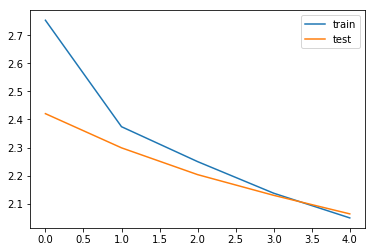

In [38]:
model_json = model.to_json()
with open("model.json", "w") as j_file:
    j_file.write(model_json)

# save the weights
model.save_weights("model_2.h5")

from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [88]:


reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index


In [ ]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [61]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [62]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: thai kitchen stir fry rice noodles extremely easy prepare taste wonderfully rich would even use substitute egg noodles lot food allergies find alternative wheat noodles 
Original summary: rice noodles 


Predicted summary:  great product


Review: love stuff currently deployed afghanistan working extremely long hours keep delicious little kits office sleeping area saved many times could leave get complete meal dining facility love 
Original summary: life saver 
Predicted summary:  great


Review: started using nustevia several years ago back purchase health food store thanks amazon order within days never run product best tried several stevia products taste nustevia please try 
Original summary: best alternative to sugar 


Predicted summary:  great product


Review: great product mushroom one ones soy ones mentioned individual flavors textures great treat long day office want something healthy reasonably low calorie tried enjoyed varieties highly recommended 
Original summary: great high protein snack option 


Predicted summary:  great product


Review: coffee full robust flavor great alone meal 
Original summary: full flavor 


Predicted summary:  great coffee


Review: gotta love peanut butter calories fat perfect use peanut butter alone healthy protein shake 
Original summary: amazing stuff 


Predicted summary:  great


Review: super tasty great consistency bar tartness cranberries plays great balance nuts grains perfect cal snack 
Original summary: great 


Predicted summary:  great


Review: toy great dog loves feed dog food eat fast beginning took sometime learn get treats eats whole cup minutes 
Original summary: great for your dog 
Predicted summary: 

 great tea


Review: much flavor remembered previous purchase tea local grocery store could get locally anymore wondering product discontinued old merchandise 
Original summary: product tasted stale to 
Predicted summary:  great product


Review: thought product superior every way packaging color taste etc buy soon needed 
Original summary: love 


Predicted summary:  great product


Review: looking tastes good favorite consistency bit runny chunks garlic quite tasty 
Original summary: bit pricey but yummy 


Predicted summary:  great


Review: love chips healthier regular ones taste great lots bbq flavor sprinkling like chips 
Original summary: bbq pop chips are amazing 


Predicted summary:  great chips


Review: cat loved chicken pot pie skeptical even ate carrots amazing 
Original summary: my cat gave these stars 


Predicted summary:  great


Review: coffee aromatic flavorful product arrived quickly would recommend coffee anyone milder less robust coffee still flavorful enjoyable 
Original summary: delicious 


Predicted summary:  great coffee


Review: tried many simply best con addictive fatty 
Original summary: the best 
Predicted summary:  great




Review: drinking stuff least years europe popular sweet like orange sodas tastes amazing 
Original summary: the best 
Predicted summary:  great


Review: really choice comes soy dairy free baking uses palm kernel oil consistancy regular seems bake fine need soy dairy free highly recommend 
Original summary: the only soy and free 
Predicted summary:  great


Review: cookies great slight tapioca flour taste sensitive chocolate chip ones even better thank dr lucy low calorie gluten free treat 
Original summary: great crunchy sweet treat 


Predicted summary:  great taste


Review: bought recommendation someone also siberian husky say husky must fairly old old siberian husky active heavy chewer figured bottom jug one day chew pieces 
Original summary: not for dogs 
Predicted summary:  great


Review: bought realized much getting knew grocery store fault really waited seeds great way many freezer 
Original summary: the product is fine 


Predicted summary:  great product


Review: buy vanilla soy creamer use flavor better buying flavored creamers full fragrance nice easy long lasting clever way great coffee home 
Original summary: great flavor for coffee 
Predicted summary:  great


Review: awesome problem would single serving husband gluten free diet far best chips found varieties popchips bland tasty keep coming back delicious barbeque 
Original summary: 

popchips 


Predicted summary:  great


Review: coffee ok mild almost weak would buy price right 
Original summary: just ok coffee 


Predicted summary:  great


Review: tried ordering amazon first time worried getting cans little top family three consumed within two weeks great flavor great snack order 
Original summary: great taste 


Predicted summary:  great


Review: loved popcorn come shipping way top would settle next time something buy spend times shipping 
Original summary: great popcorn terrible price for shipping 


Predicted summary:  great


Review: race raw spanish peanuts best source great protein fat peanuts best bulk quality ever seen 
Original summary: terrific quality 
Predicted summary:  great




Review: use one packet per jar make yogurt almost daily happy raised price otherwise product appears work advertised bit funny taste suspect strong content 
Original summary: use 
Predicted summary:  great product


Review: aware first ingredient list salt find product peppery hot spicy disappointment 
Original summary: first ingredient on the is salt 
Predicted summary:  great product


Review: happy found wonderful decaf tea guests tea nice full flavored smooth finish usually use cup twice setting tea remains true delicious price best found anywhere 
Original summary: 

mm good tea 
Predicted summary:  great tea


Review: good green mountain reserve sumatra better half stars sort tastes little stale 
Original summary: good but not perfect 
Predicted summary:  great


Review: fresh great way get little chocolate life without calories taste like chocolate pudding 
Original summary: omg best chocolate jelly 


Predicted summary:  great


Review: hard find tomato powder reasonably priced little tomato paste sauce requires cook somehow store extra portion 
Original summary: at last priced powder 


Predicted summary:  great product


Review: wish expensive absolutely worth price care feeding dog quality grain free food 
Original summary: wonderful product 
Predicted summary:  great


Review: best eat day go quickly going tell many ive bought since jan year great love 
Original summary: addicted love them get enough 


Predicted summary:  great


Review: gave daughter uses recipes wanted use smoothies tasted bad 
Original summary: tasted 
Predicted summary:  great product


Review: love taste found many cups explode glue side cup becomes cup hard clean think buy brand 
Original summary: poor quality 


Predicted summary:  great


Review: cats favorite cat food eat lot different cat foods loves one 
Original summary: cat food 


Predicted summary:  great


Review: product wonderful however package contents bent arrived suspect lack lack air packets packaging one almost bent point puncture 
Original summary: great product poor shipping package 


Predicted summary:  great product


Review: thought would love product found rather tasteless always use vanilla chai love use teabags get decent flavor caramel 
Original summary: disappointed 


Predicted summary:  great product


Review: pill pockets great dogs love soft perfectly hides pill medication give 
Original summary: great pill pockets 


Predicted summary:  great product


Review: sooooo good addictive know carrot chips fries carrot chips think potato chips vs corn chips trying use either love hate entire family 
Original summary: love these 


Predicted summary:  great chips


Review: trouble finding easter best jelly beans ever packing slightly different jelly beans 
Original summary: best jelly beans ever 


Predicted summary:  great product


Review: children eat healthy products love graham crackers glad available amazon 
Original summary: excellent product 


Predicted summary:  great


Review: first purchased product months ago co worker mentioned decided try surprise delicious sold continue buy like hot fresh pork rinds spicy ones product summer 
Original summary: best pork rinds ever 


Predicted summary:  great product


Review: dog loves treat toys one really know else say except completely might work big dogs like rip things apart 
Original summary: it 


Predicted summary:  great tea


Review: looking treat whose protein low made usa organic size treats us quarter 
Original summary: perfect 


Predicted summary:  great


Review: wife loves oatmeal cannot always find get good price hope keep carrying 
Original summary: oats oatmeal 
Predicted summary:

  great


Review: like chips lot whole pack get chips fish 
Original summary: yum yum love me pop chips 
Predicted summary:  great chips




Review: product delicious mix lot coffee shops use disappointed 
Original summary: delicious 
Predicted summary:  great product


Review: wafer rolls delivered large amount breakage taste good would nice something wafer rather crumbs however price right 
Original summary: all natural 


Predicted summary:  great product


Review: skeptical quality hot chocolate cup grove square amazing good making scratch without fuss milk chocolate mild dark enough bite make interesting peppermint perfect dinner 
Original summary: excellent hot 


Predicted summary:  great popcorn


Review: found peanuts years ago lived virginia although moved united states still order regular basis use best nuts cook right crunch great flavor expect virginia style peanuts 
Original summary: great tasting nuts 


Predicted summary:  great product


Review: opinion far best tasting cup flavored drink tried distinct coffee flavor strong light 
Original summary: the best kcup flavor out there 
Predicted summary:  great


Review: changing kitty food dry wet tried many different flavors favorite mixed dry food first three days gave canned salmon bowl clean 
Original summary: winner for my picky cat 


Predicted summary:  great


Review: way like bold full flavored drink black love taste favorite around house 
Original summary: this is bold 


Predicted summary:  great


Review: add chia seeds morning shake breakfast love taste great almost like tiny better particular bag last long time considering consume daily also cheaper stores def recommend product 
Original summary: chia seeds 


Predicted summary:  great


Review: makes great nut butters chocolate version like nutella less sugar crap delicious super nutritious 
Original summary: quality nut 


Predicted summary:  great


Review: love brewing chamomile tea scratch one best things help fall day work great stuff great price 
Original summary: great value and wonderful tea 
Predicted summary:

  great tea


Review: naturals chia seed become favorite easy set next delivery date enjoy healthy seeds sad amazon removed auto ship program continue buy long available health benefits 
Original summary: this can no be 
Predicted summary:  great product


Review: dog food ran two weeks ago local source bought called equivalent see suffer itching belly aches ordered amazon yesterday free shipping sent hours later recieved today 
Original summary: newman own organic dog food 


Predicted summary:  great tea


Review: use twins love never problems wish cheaper 
Original summary: worked great for us 
Predicted summary:  great


Review: ordered year ago repeatedly ordered since everyone shared loved much also gotten right amazon ordered also mix coffee feeling particularly top cream delicious 
Original summary: totally 


Predicted summary:  great product


Review: paul makes great seafood seasoning pork seasoning found vegetable seasoning spicy 
Original summary: seasoning very spicy 


Predicted summary:  great


Review: deployed love treat reminds home popular home times 
Original summary: treat from home 
Predicted summary:

  great


Review: really good like make little extra milk thin cannot even tell difference regular pancakes worth price family 
Original summary: good gluten free pancakes 
Predicted summary:  great


Review: good side dish easy make easy eat others said needs little spice delicious 
Original summary: 

very good 
Predicted summary:  great


Review: pour oil cooked pasta fry eggs use everything calls butter superb olive oil 
Original summary: perfect for cooking 


Predicted summary:  great


Review: exactly advertised plenty space set keurig brewer top still fit counter top cups nicely drawer easy access see cups may want 
Original summary: cup 


Predicted summary:  great product


Review: tea usa know mandarin silk loose leaf oolong tea like name suggests silk silk tongue tea warm relaxing taste makes feel wonderful well done tea 
Original summary: awesome 
Predicted summary: 

 great tea


Review: bought yesterday local store expiration really smelled bad supposed open every single smell test buying 
Original summary: bad smell 


Predicted summary:  great product


Review: cookies truly favorite beyond make cook whole wheat version particularly superb greater flavor original lovely slightly crumbly grainy texture wonderful bon 
Original summary: with perfect packaging 
Predicted summary: 

 great taste


Review: really enjoy low calorie chips good flavor good crunch crisp wondering ordering case chips one could order favorites whole flavors say flavors desired great product stop manufacturing 
Original summary: yummy 
Predicted summary:  great chips


Review: understand dog food full reviews give dog food stars beats science diet purina one use use diamond natural less expensive 
Original summary: quality at good price 
Predicted summary:  great tea


Review: first tea restaurant immediately tasted natural sweetness tea bitter tea sweet like perfect cup tea 
Original summary: no needed 


Predicted summary:  great tea


Review: product excellent tried one night quick easy dinner whole family loved including fussy year old daughter well worth trying 
Original summary: excellent flavor 


Predicted summary:  great product


Review: ordered many kind bars amazon disappointed time bars taste good hard rocks taking chance trip biting could find place let amazon know posted maybe problem 
Original summary: good but not well 


Predicted summary:  great product


Review: closest thing movie popcorn every kernel pops great flavor recommend popcorn anyone likes theater popcorn 
Original summary: best popcorn 


Predicted summary:  great


Review: price excellent tea arrived quickly buying tea future 
Original summary: tea 


Predicted summary:  great tea


Review: tastes great got fast ordered air popper sister loved much 
Original summary: popcorn 


Predicted summary:  great


Review: coffee sample selection ordered keurig brewer far favorite ordered coffee several times amazon dark roast strong 
Original summary: wolfgang puck coffee for keurig 


Predicted summary:  great coffee


Review: tried mixes pancakes awful one really good buy stock co people buying product sure 
Original summary: really good mix 


Predicted summary:  great


Review: reading earlier reviews bad packaging bit hesitant ordering favourite biscuits thought give try product got delivered simply superb quality packaging amazon 
Original summary: simply superb packaging shipping 


Predicted summary:  great product


Review: excellent product always ran olive juice ran olives making dirty martinis terrific source great tasting olive juice dirty martinis never better 
Original summary: dirty olive juice 


Predicted summary:  great product


Review: tried many corn soy ingredients list automatic soy corn modified unless says organic non gmo gm eat gm products feed pets 
Original summary: ingredients no thank you 


Predicted summary:  great product


Review: kind bitter recommend buying first store buying case almost strips great portable vegetarian protein snack 
Original summary: high protein and vegetarian but bit bitter 


Predicted summary:  great


Review: made according package directions added cup mini chocolate chips awesome took longer cook box says maybe chocolate chips either way great definitely make 
Original summary: yummy 


Predicted summary:  great


Review: great snacking healthy bags filled smaller snacks reordering regular basis 
Original summary: absolutely yummy 


Predicted summary:  great


Review: delicious flavorful tea must cinnamon lovers also pleasant sweetness even us use sweeteners enjoy wonderful hot drink especially like cold drink 
Original summary: if you like cinnamon 


Predicted summary:  great tea


Review: fool italian husband fool anyone think consistency close wheat pasta cannot wait try laws 
Original summary: this rice pasta is 


Predicted summary:  great product


Review: dog loves treats yorkie right size let friend give dog loved also 
Original summary: best buddy bones 


Predicted summary:  great tea


Review: really enjoy coffee recommend store airtight container opening maintain full flavor enjoy evening coffee 
Original summary: great raspberry flavor 


Predicted summary:  great


Review: keeps dog entertained get sometimes never one playing toys staying one thing period time seem like though 
Original summary: busy buddy 


Predicted summary:  great tea


Review: water based sardines without salt bad product far superior types normally purchase stores 
Original summary: water low sodium that actually taste good 


Predicted summary:  great product


Review: great tasting coffee good first thing morning anytime smooth green mountain puts great tasting coffee flavors blends 
Original summary: very good 


Predicted summary:  great coffee


Review: search treats made came made 
Original summary: made in china 


Predicted summary:  great


Review: wasnt sure would even like keurig coffee maker like strong coffee wonderful us like mild brews plus little cups convienient recommend product 
Original summary: glad this great price 


Predicted summary:  great coffee


Review: never enough juice left jar olives therefore end olives eat buying juice makes alot sense 
Original summary: my husband loves dirty 


Predicted summary:  great product


Review: combine libby organic black beans libby organic green beans mixed bob red mill organic brown rice least two three times per week perfect meal every time 
Original summary: goes great with black beans and rice 


Predicted summary:  great product


Review: popcorn microwave cheese popcorn tastes somehow must cheese packet tastes yummy 
Original summary: yum 


Predicted summary:  great


Review: get good one bone ordered thinking getting cute basket bones value let picture item worth merrick smoked jerky bone 
Original summary: dog treats 


Predicted summary:  great product




In [79]:
from tensorflow.keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('model.h5')


# del model


ValueError: Unknown layer: AttentionLayer

In [86]:
model = load_model('model.h5', custom_objects={'AttentionLayer': AttentionLayer})

In [87]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [89]:


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [90]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [91]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: thai kitchen stir fry rice noodles extremely easy prepare taste wonderfully rich would even use substitute egg noodles lot food allergies find alternative wheat noodles 
Original summary: rice noodles 


Predicted summary:  great product


Review: love stuff currently deployed afghanistan working extremely long hours keep delicious little kits office sleeping area saved many times could leave get complete meal dining facility love 
Original summary: life saver 
Predicted summary:  great


Review: started using nustevia several years ago back purchase health food store thanks amazon order within days never run product best tried several stevia products taste nustevia please try 
Original summary: best alternative to sugar 


Predicted summary:  great product


Review: great product mushroom one ones soy ones mentioned individual flavors textures great treat long day office want something healthy reasonably low calorie tried enjoyed varieties highly recommended 
Original summary: great high protein snack option 


Predicted summary:  great product


Review: coffee full robust flavor great alone meal 
Original summary: full flavor 


Predicted summary:  great coffee


Review: gotta love peanut butter calories fat perfect use peanut butter alone healthy protein shake 
Original summary: amazing stuff 
Predicted summary:

  great


Review: super tasty great consistency bar tartness cranberries plays great balance nuts grains perfect cal snack 
Original summary: great 
Predicted summary:  great


Review: toy great dog loves feed dog food eat fast beginning took sometime learn get treats eats whole cup minutes 
Original summary: great for your dog 


Predicted summary:  great tea


Review: much flavor remembered previous purchase tea local grocery store could get locally anymore wondering product discontinued old merchandise 
Original summary: product tasted stale to 


Predicted summary:  great product


Review: thought product superior every way packaging color taste etc buy soon needed 
Original summary: love 


Predicted summary:  great product


Review: looking tastes good favorite consistency bit runny chunks garlic quite tasty 
Original summary: bit pricey but yummy 


Predicted summary:  great


Review: love chips healthier regular ones taste great lots bbq flavor sprinkling like chips 
Original summary: bbq pop chips are amazing 


Predicted summary:  great chips


Review: cat loved chicken pot pie skeptical even ate carrots amazing 
Original summary: my cat gave these stars 


Predicted summary:  great


Review: coffee aromatic flavorful product arrived quickly would recommend coffee anyone milder less robust coffee still flavorful enjoyable 
Original summary: delicious 


Predicted summary:  great coffee


Review: tried many simply best con addictive fatty 
Original summary: the best 


Predicted summary:  great


Review: drinking stuff least years europe popular sweet like orange sodas tastes amazing 
Original summary: the best 
Predicted summary:

  great


Review: really choice comes soy dairy free baking uses palm kernel oil consistancy regular seems bake fine need soy dairy free highly recommend 
Original summary: the only soy and free 
Predicted summary:

  great


Review: cookies great slight tapioca flour taste sensitive chocolate chip ones even better thank dr lucy low calorie gluten free treat 
Original summary: great crunchy sweet treat 
Predicted summary:

  great taste


Review: bought recommendation someone also siberian husky say husky must fairly old old siberian husky active heavy chewer figured bottom jug one day chew pieces 
Original summary: not for dogs 
Predicted summary:

  great


Review: bought realized much getting knew grocery store fault really waited seeds great way many freezer 
Original summary: the product is fine 
Predicted summary:  great product


Review: buy vanilla soy creamer use flavor better buying flavored creamers full fragrance nice easy long lasting clever way great coffee home 
Original summary: great flavor for coffee 


Predicted summary:  great


Review: awesome problem would single serving husband gluten free diet far best chips found varieties popchips bland tasty keep coming back delicious barbeque 
Original summary: popchips 
Predicted summary:  great




Review: coffee ok mild almost weak would buy price right 
Original summary: just ok coffee 
Predicted summary:  great


Review: tried ordering amazon first time worried getting cans little top family three consumed within two weeks great flavor great snack order 
Original summary: great taste 
Predicted summary:  great


Review: loved popcorn come shipping way top would settle next time something buy spend times shipping 
Original summary: great popcorn terrible price for shipping 


Predicted summary:  great


Review: race raw spanish peanuts best source great protein fat peanuts best bulk quality ever seen 
Original summary: terrific quality 


Predicted summary:  great


Review: use one packet per jar make yogurt almost daily happy raised price otherwise product appears work advertised bit funny taste suspect strong content 
Original summary: use 


Predicted summary:  great product


Review: aware first ingredient list salt find product peppery hot spicy disappointment 
Original summary: first ingredient on the is salt 


Predicted summary:  great product


Review: happy found wonderful decaf tea guests tea nice full flavored smooth finish usually use cup twice setting tea remains true delicious price best found anywhere 
Original summary: mm good tea 


Predicted summary:  great tea


Review: good green mountain reserve sumatra better half stars sort tastes little stale 
Original summary: good but not perfect 


Predicted summary:  great


Review: fresh great way get little chocolate life without calories taste like chocolate pudding 
Original summary: omg best chocolate jelly 


Predicted summary:  great


Review: hard find tomato powder reasonably priced little tomato paste sauce requires cook somehow store extra portion 
Original summary: at last priced powder 


Predicted summary:  great product


Review: wish expensive absolutely worth price care feeding dog quality grain free food 
Original summary: wonderful product 


Predicted summary:  great


Review: best eat day go quickly going tell many ive bought since jan year great love 
Original summary: addicted love them get enough 
Predicted summary:  great




Review: gave daughter uses recipes wanted use smoothies tasted bad 
Original summary: tasted 
Predicted summary:  great product


Review: love taste found many cups explode glue side cup becomes cup hard clean think buy brand 
Original summary: poor quality 
Predicted summary: 

 great


Review: cats favorite cat food eat lot different cat foods loves one 
Original summary: cat food 
Predicted summary:  great


Review: product wonderful however package contents bent arrived suspect lack lack air packets packaging one almost bent point puncture 
Original summary: great product poor shipping package 
Predicted summary: 

 great product


Review: thought would love product found rather tasteless always use vanilla chai love use teabags get decent flavor caramel 
Original summary: disappointed 
Predicted summary:  great product


Review: pill pockets great dogs love soft perfectly hides pill medication give 
Original summary: great pill pockets 
Predicted summary:  great product


Review: sooooo good addictive know carrot chips fries carrot chips think potato chips vs corn chips trying use either love hate entire family 
Original summary: love these 


Predicted summary:  great chips


Review: trouble finding easter best jelly beans ever packing slightly different jelly beans 
Original summary: best jelly beans ever 


Predicted summary:  great product


Review: children eat healthy products love graham crackers glad available amazon 
Original summary: excellent product 


Predicted summary:  great


Review: first purchased product months ago co worker mentioned decided try surprise delicious sold continue buy like hot fresh pork rinds spicy ones product summer 
Original summary: best pork rinds ever 


Predicted summary:  great product


Review: dog loves treat toys one really know else say except completely might work big dogs like rip things apart 
Original summary: it 


Predicted summary:  great tea


Review: looking treat whose protein low made usa organic size treats us quarter 
Original summary: perfect 


Predicted summary:  great


Review: wife loves oatmeal cannot always find get good price hope keep carrying 
Original summary: oats oatmeal 
Predicted summary:  great


Review: like chips lot whole pack get chips fish 
Original summary: 

yum yum love me pop chips 
Predicted summary:  great chips


Review: product delicious mix lot coffee shops use disappointed 
Original summary: delicious 


Predicted summary:  great product


Review: wafer rolls delivered large amount breakage taste good would nice something wafer rather crumbs however price right 
Original summary: all natural 


Predicted summary:  great product


Review: skeptical quality hot chocolate cup grove square amazing good making scratch without fuss milk chocolate mild dark enough bite make interesting peppermint perfect dinner 
Original summary: excellent hot 
Predicted summary:  great popcorn


Review: found peanuts years ago lived virginia although moved united states still order regular basis use best nuts cook right crunch great flavor expect virginia style peanuts 
Original summary: great tasting nuts 


Predicted summary:  great product


Review: opinion far best tasting cup flavored drink tried distinct coffee flavor strong light 
Original summary: the best kcup flavor out there 
Predicted summary:

  great


Review: changing kitty food dry wet tried many different flavors favorite mixed dry food first three days gave canned salmon bowl clean 
Original summary: winner for my picky cat 


Predicted summary:  great


Review: way like bold full flavored drink black love taste favorite around house 
Original summary: this is bold 
Predicted summary:

  great


Review: add chia seeds morning shake breakfast love taste great almost like tiny better particular bag last long time considering consume daily also cheaper stores def recommend product 
Original summary: chia seeds 
Predicted summary:  great


Review: makes great nut butters chocolate version like nutella less sugar crap delicious super nutritious 
Original summary: quality nut 


Predicted summary:  great


Review: love brewing chamomile tea scratch one best things help fall day work great stuff great price 
Original summary: great value and wonderful tea 


Predicted summary:  great tea


Review: naturals chia seed become favorite easy set next delivery date enjoy healthy seeds sad amazon removed auto ship program continue buy long available health benefits 
Original summary: this can no be 


Predicted summary:  great product


Review: dog food ran two weeks ago local source bought called equivalent see suffer itching belly aches ordered amazon yesterday free shipping sent hours later recieved today 
Original summary: newman own organic dog food 


Predicted summary:  great tea


Review: use twins love never problems wish cheaper 
Original summary: worked great for us 


Predicted summary:  great


Review: ordered year ago repeatedly ordered since everyone shared loved much also gotten right amazon ordered also mix coffee feeling particularly top cream delicious 
Original summary: totally 


Predicted summary:  great product


Review: paul makes great seafood seasoning pork seasoning found vegetable seasoning spicy 
Original summary: seasoning very spicy 


Predicted summary:  great


Review: deployed love treat reminds home popular home times 
Original summary: treat from home 


Predicted summary:  great


Review: really good like make little extra milk thin cannot even tell difference regular pancakes worth price family 
Original summary: good gluten free pancakes 


Predicted summary:  great


Review: good side dish easy make easy eat others said needs little spice delicious 
Original summary: very good 


Predicted summary:  great


Review: pour oil cooked pasta fry eggs use everything calls butter superb olive oil 
Original summary: perfect for cooking 


Predicted summary:  great


Review: exactly advertised plenty space set keurig brewer top still fit counter top cups nicely drawer easy access see cups may want 
Original summary: cup 


Predicted summary:  great product


Review: tea usa know mandarin silk loose leaf oolong tea like name suggests silk silk tongue tea warm relaxing taste makes feel wonderful well done tea 
Original summary: awesome 


Predicted summary:  great tea


Review: bought yesterday local store expiration really smelled bad supposed open every single smell test buying 
Original summary: bad smell 


Predicted summary:  great product


Review: cookies truly favorite beyond make cook whole wheat version particularly superb greater flavor original lovely slightly crumbly grainy texture wonderful bon 
Original summary: with perfect packaging 


Predicted summary:  great taste


Review: really enjoy low calorie chips good flavor good crunch crisp wondering ordering case chips one could order favorites whole flavors say flavors desired great product stop manufacturing 
Original summary: yummy 


Predicted summary:  great chips


Review: understand dog food full reviews give dog food stars beats science diet purina one use use diamond natural less expensive 
Original summary: quality at good price 


Predicted summary:  great tea


Review: first tea restaurant immediately tasted natural sweetness tea bitter tea sweet like perfect cup tea 
Original summary: no needed 


Predicted summary:  great tea


Review: product excellent tried one night quick easy dinner whole family loved including fussy year old daughter well worth trying 
Original summary: excellent flavor 


Predicted summary:  great product


Review: ordered many kind bars amazon disappointed time bars taste good hard rocks taking chance trip biting could find place let amazon know posted maybe problem 
Original summary: good but not well 


Predicted summary:  great product


Review: closest thing movie popcorn every kernel pops great flavor recommend popcorn anyone likes theater popcorn 
Original summary: best popcorn 


Predicted summary:  great


Review: price excellent tea arrived quickly buying tea future 
Original summary: tea 


Predicted summary:  great tea


Review: tastes great got fast ordered air popper sister loved much 
Original summary: popcorn 


Predicted summary:  great


Review: coffee sample selection ordered keurig brewer far favorite ordered coffee several times amazon dark roast strong 
Original summary: wolfgang puck coffee for keurig 


Predicted summary:  great coffee


Review: tried mixes pancakes awful one really good buy stock co people buying product sure 
Original summary: really good mix 


Predicted summary:  great


Review: reading earlier reviews bad packaging bit hesitant ordering favourite biscuits thought give try product got delivered simply superb quality packaging amazon 
Original summary: simply superb packaging shipping 


Predicted summary:  great product


Review: excellent product always ran olive juice ran olives making dirty martinis terrific source great tasting olive juice dirty martinis never better 
Original summary: dirty olive juice 


Predicted summary:  great product


Review: tried many corn soy ingredients list automatic soy corn modified unless says organic non gmo gm eat gm products feed pets 
Original summary: ingredients no thank you 


Predicted summary:  great product


Review: kind bitter recommend buying first store buying case almost strips great portable vegetarian protein snack 
Original summary: high protein and vegetarian but bit bitter 


Predicted summary:  great


Review: made according package directions added cup mini chocolate chips awesome took longer cook box says maybe chocolate chips either way great definitely make 
Original summary: yummy 


Predicted summary:  great


Review: great snacking healthy bags filled smaller snacks reordering regular basis 
Original summary: absolutely yummy 


Predicted summary:  great


Review: delicious flavorful tea must cinnamon lovers also pleasant sweetness even us use sweeteners enjoy wonderful hot drink especially like cold drink 
Original summary: if you like cinnamon 


Predicted summary:  great tea


Review: fool italian husband fool anyone think consistency close wheat pasta cannot wait try laws 
Original summary: this rice pasta is 


Predicted summary:  great product


Review: dog loves treats yorkie right size let friend give dog loved also 
Original summary: best buddy bones 


Predicted summary:  great tea


Review: really enjoy coffee recommend store airtight container opening maintain full flavor enjoy evening coffee 
Original summary: great raspberry flavor 


Predicted summary:  great


Review: keeps dog entertained get sometimes never one playing toys staying one thing period time seem like though 
Original summary: busy buddy 


Predicted summary:  great tea


Review: water based sardines without salt bad product far superior types normally purchase stores 
Original summary: water low sodium that actually taste good 


Predicted summary:  great product


Review: great tasting coffee good first thing morning anytime smooth green mountain puts great tasting coffee flavors blends 
Original summary: very good 


Predicted summary:  great coffee


Review: search treats made came made 
Original summary: made in china 


Predicted summary:  great


Review: wasnt sure would even like keurig coffee maker like strong coffee wonderful us like mild brews plus little cups convienient recommend product 
Original summary: glad this great price 


Predicted summary:  great coffee


Review: never enough juice left jar olives therefore end olives eat buying juice makes alot sense 
Original summary: my husband loves dirty 


Predicted summary:  great product


Review: combine libby organic black beans libby organic green beans mixed bob red mill organic brown rice least two three times per week perfect meal every time 
Original summary: goes great with black beans and rice 


Predicted summary:  great product


Review: popcorn microwave cheese popcorn tastes somehow must cheese packet tastes yummy 
Original summary: yum 


Predicted summary:  great


Review: get good one bone ordered thinking getting cute basket bones value let picture item worth merrick smoked jerky bone 
Original summary: dog treats 


Predicted summary:  great product


